### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

In [2]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Eye Tracking/PreciousTest1 Data export.tsv'

In [3]:
main_df = pd.read_csv(file_path, sep='\t')

<ipython-input-3-ebca4a118eb0>:1: DtypeWarning: Columns (37,38,76) have mixed types. Specify dtype option on import or set low_memory=False.
  main_df = pd.read_csv(file_path, sep='\t')


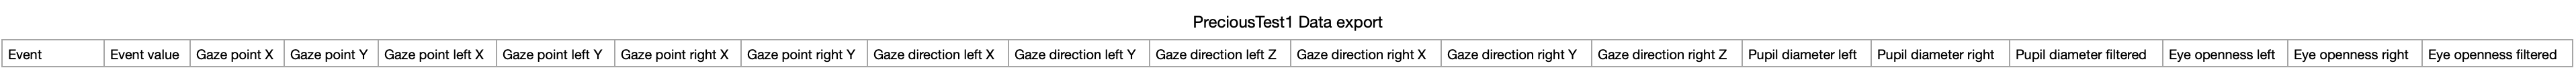

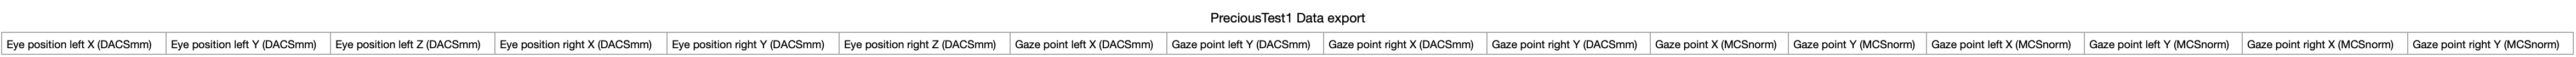

In [4]:
main_df['Event'].unique()

array(['RecordingStart', nan, 'Eye tracker Calibration start',
       'MouseEvent', 'Eye tracker Calibration end', 'VideoStimulusStart',
       'VideoStimulusEnd', 'RecordingEnd'], dtype=object)

In [5]:
columns_to_extract = [
    "Eyetracker timestamp",
    "Event",
    "Event value",
    "Gaze point X",
    "Gaze point Y",
    "Gaze point left X",
    "Gaze point left Y",
    "Gaze point right X",
    "Gaze point right Y",
    "Gaze direction left X",
    "Gaze direction left Y",
    "Gaze direction right X",
    "Gaze direction right Y",
    "Pupil diameter left",
    "Pupil diameter right",
    "Pupil diameter filtered",
    "Eye openness left",
    "Eye openness right",
    "Eye openness filtered"
]

In [6]:
eye_specific_df = main_df[columns_to_extract]

In [7]:
eye_specific_df.head(200)

,Eyetracker timestamp,Event,Event value,Gaze point X,Gaze point Y,Gaze point left X,Gaze point left Y,Gaze point right X,Gaze point right Y,Gaze direction left X,Gaze direction left Y,Gaze direction right X,Gaze direction right Y,Pupil diameter left,Pupil diameter right,Pupil diameter filtered,Eye openness left,Eye openness right,Eye openness filtered
0,NaN,RecordingStart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.414903e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.414903e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.414903e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.414903e+12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2.414904e+12,NaN,NaN,1006.0,593.0,1016.0,584.0,997.0,602.0,0.09312,0.18953,0.01286,0.19539,4.270,3.999,4.110,8.540,8.565,8.636
196,2.414904e+12,NaN,NaN,1000.0,598.0,1003.0,583.0,996.0,612.0,0.08675,0.18879,0.01102,0.19844,4.262,4.035,4.111,8.606,8.850,8.667
197,2.414904e+12,NaN,NaN,991.0,570.0,990.0,558.0,992.0,582.0,0.08035,0.17894,0.00811,0.18666,4.218,3.981,4.122,8.707,8.666,8.720
198,2.414904e+12,NaN,NaN,996.0,579.0,1011.0,562.0,981.0,596.0,0.08651,0.17976,0.00253,0.19097,4.237,3.982,4.109,8.762,8.883,8.726


In [8]:
eye_specific_df.to_csv('tobii_data_just_gazepoint_for_precious_test_one.csv', index=False)

### Calibration and Saccade Data Extraction

In [9]:
def split_eye_tracking_data(df, output_file):

    # Convert unix time in microseconds to utc; then extract minute, second, and microsecond.
    df['Eyetracker timestamp'] = pd.to_datetime(df['Eyetracker timestamp'], unit='us', utc=True)
    df['Eyetracker timestamp'] = df['Eyetracker timestamp'].dt.tz_localize(None)
    df['Seconds'] = (
    df['Eyetracker timestamp'].dt.minute * 60 +
    df['Eyetracker timestamp'].dt.second +
    df['Eyetracker timestamp'].dt.microsecond / 1_000_000).round(3)

    # Initialize variables to store different parts of the data
    calibration_data = []
    calibration_trace_data = []
    saccade_trace_data = []

    # Flags to track the current section
    in_calibration = False
    in_calibration_trace = False
    in_saccade_trace = False

    for index, row in df.iterrows():
        event = row['Event']
        event_value = row['Event value']

        # Check for the start and end of each section
        if event == 'Eye tracker Calibration start':
            in_calibration = True
        elif event == 'Eye tracker Calibration end':
            in_calibration = False
        elif event == 'VideoStimulusStart' and event_value == 'calibration trace video':
            in_calibration_trace = True
        elif event == 'VideoStimulusEnd' and event_value == 'calibration trace video':
            in_calibration_trace = False
        elif event == 'VideoStimulusStart' and event_value == 'saccades trace video':
            in_saccade_trace = True
        elif event == 'VideoStimulusEnd' and event_value == 'saccades trace video':
            in_saccade_trace = False
        elif event == 'RecordingEnd':
            break  # Stop processing after the first 'RecordingEnd'

        # Append rows to respective lists based on the current section.
        if in_calibration:
            calibration_data.append(row)
        elif in_calibration_trace:
            calibration_trace_data.append(row)
        elif in_saccade_trace:
            saccade_trace_data.append(row)

    calibration_df = pd.DataFrame(calibration_data, columns=df.columns)
    calibration_trace_df = pd.DataFrame(calibration_trace_data, columns=df.columns)
    saccade_trace_df = pd.DataFrame(saccade_trace_data, columns=df.columns)

    columns_to_check = ['Gaze point left X', 'Gaze point left Y', 'Gaze point right X', 'Gaze point right Y']

    calibration_df.dropna(subset=columns_to_check, inplace=True)
    calibration_trace_df.dropna(subset=columns_to_check, inplace=True)
    saccade_trace_df.dropna(subset=columns_to_check, inplace=True)

    with pd.ExcelWriter(output_file) as writer:
        calibration_df.to_excel(writer, sheet_name='Tobii Calibration Data', index=False)
        calibration_trace_df.to_excel(writer, sheet_name='Calibration Trace Video', index=False)
        saccade_trace_df.to_excel(writer, sheet_name='Saccades Trace Video', index=False)

    return calibration_df, calibration_trace_df, saccade_trace_df

In [ ]:
output_file = 'final_tobii_data.xlsx'
calibration_df, calibration_trace_df, saccade_trace_df = split_eye_tracking_data(eye_specific_df, output_file)

In [11]:
# rows of data in each file
print(calibration_df.shape, saccade_trace_df.shape, calibration_trace_df.shape)

(16517, 20) (15818, 20) (5533, 20)


In [14]:
# Number of missing values cleaned up
calibration_trace_df.isna().sum()

,0
Eyetracker timestamp,81
Event,5712
Event value,5712
Gaze point X,164
Gaze point Y,164
Gaze point left X,179
Gaze point left Y,179
Gaze point right X,167
Gaze point right Y,167
Gaze direction left X,179


In [13]:
calibration_trace_df.isna().sum()

,0
Eyetracker timestamp,0
Event,5533
Event value,5533
Gaze point X,0
Gaze point Y,0
Gaze point left X,0
Gaze point left Y,0
Gaze point right X,0
Gaze point right Y,0
Gaze direction left X,0


In [14]:
calibration_df.head()

,Eyetracker timestamp,Event,Event value,Gaze point X,Gaze point Y,Gaze point left X,Gaze point left Y,Gaze point right X,Gaze point right Y,Gaze direction left X,Gaze direction left Y,Gaze direction right X,Gaze direction right Y,Pupil diameter left,Pupil diameter right,Pupil diameter filtered,Eye openness left,Eye openness right,Eye openness filtered,Seconds
100,1970-01-28 22:48:23.448084,NaN,NaN,285.0,252.0,302.0,229.0,269.0,275.0,-0.14822,0.09058,-0.22635,0.10475,4.734,4.618,4.630,7.817,7.351,7.493,2903.448
101,1970-01-28 22:48:23.456418,NaN,NaN,272.0,222.0,298.0,206.0,246.0,237.0,-0.14872,0.08169,-0.23311,0.09050,4.673,4.599,4.635,7.392,7.389,7.530,2903.456
102,1970-01-28 22:48:23.464751,NaN,NaN,298.0,242.0,295.0,185.0,300.0,300.0,-0.14849,0.07337,-0.21338,0.11214,4.624,4.664,4.646,7.555,7.528,7.542,2903.465
103,1970-01-28 22:48:23.473086,NaN,NaN,298.0,254.0,299.0,233.0,296.0,275.0,-0.14577,0.08973,-0.21384,0.10260,4.668,4.602,4.643,7.744,7.654,7.542,2903.473
104,1970-01-28 22:48:23.481420,NaN,NaN,296.0,252.0,306.0,237.0,286.0,267.0,-0.14201,0.09046,-0.21605,0.09894,4.677,4.619,4.643,7.537,7.688,7.651,2903.481


In [15]:
saccade_trace_df.head()

,Eyetracker timestamp,Event,Event value,Gaze point X,Gaze point Y,Gaze point left X,Gaze point left Y,Gaze point right X,Gaze point right Y,Gaze direction left X,Gaze direction left Y,Gaze direction right X,Gaze direction right Y,Pupil diameter left,Pupil diameter right,Pupil diameter filtered,Eye openness left,Eye openness right,Eye openness filtered,Seconds
27000,1970-01-28 22:51:52.686978,NaN,NaN,950.0,462.0,942.0,445.0,957.0,478.0,0.01793,0.13045,-0.06425,0.14047,2.728,2.767,2.762,9.930,9.658,9.817,3112.687
27001,1970-01-28 22:51:52.695311,NaN,NaN,950.0,468.0,944.0,449.0,957.0,488.0,0.01890,0.13225,-0.06434,0.14484,2.743,2.792,2.767,9.958,9.683,9.823,3112.695
27002,1970-01-28 22:51:52.703644,NaN,NaN,947.0,473.0,938.0,457.0,956.0,489.0,0.01609,0.13554,-0.06474,0.14515,2.721,2.785,2.756,9.950,9.735,9.821,3112.704
27003,1970-01-28 22:51:52.711978,NaN,NaN,948.0,471.0,938.0,457.0,958.0,485.0,0.01630,0.13580,-0.06359,0.14339,2.743,2.804,2.755,10.015,9.749,9.849,3112.712
27004,1970-01-28 22:51:52.720311,NaN,NaN,956.0,467.0,941.0,457.0,971.0,477.0,0.01761,0.13579,-0.05771,0.14004,2.725,2.767,2.755,10.072,9.621,9.818,3112.720


In [16]:
calibration_trace_df.head()

,Eyetracker timestamp,Event,Event value,Gaze point X,Gaze point Y,Gaze point left X,Gaze point left Y,Gaze point right X,Gaze point right Y,Gaze direction left X,Gaze direction left Y,Gaze direction right X,Gaze direction right Y,Pupil diameter left,Pupil diameter right,Pupil diameter filtered,Eye openness left,Eye openness right,Eye openness filtered,Seconds
21284,1970-01-28 22:51:05.737595,NaN,NaN,1014.0,736.0,1031.0,796.0,996.0,677.0,0.01961,0.33686,-0.09723,0.27144,2.919,3.631,3.275,5.144,6.228,5.686,3065.738
21301,1970-01-28 22:51:05.845926,NaN,NaN,883.0,527.0,877.0,555.0,890.0,499.0,-0.05392,0.22125,-0.14796,0.18287,3.578,3.509,3.543,7.120,6.798,6.959,3065.846
21303,1970-01-28 22:51:05.854259,NaN,NaN,885.0,489.0,878.0,488.0,892.0,490.0,-0.05295,0.18683,-0.14668,0.17844,3.663,3.772,3.679,7.589,7.049,7.319,3065.854
21304,1970-01-28 22:51:05.862593,NaN,NaN,887.0,410.0,879.0,399.0,896.0,422.0,-0.05241,0.14074,-0.14485,0.14344,3.701,3.836,3.745,7.627,7.333,7.480,3065.863
21306,1970-01-28 22:51:05.870925,NaN,NaN,888.0,359.0,876.0,341.0,899.0,378.0,-0.05342,0.10974,-0.14313,0.12074,3.587,3.827,3.768,8.205,7.590,7.896,3065.871


## Visualize Saccades

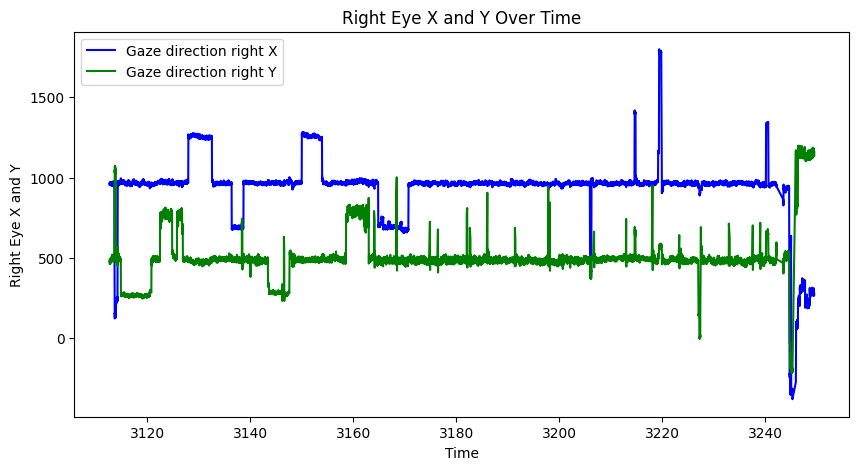

In [17]:
plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(saccade_trace_df['Seconds'], saccade_trace_df['Gaze point right X'], label='Gaze direction right X', color='blue')
plt.plot(saccade_trace_df['Seconds'], saccade_trace_df['Gaze point right Y'], label='Gaze direction right Y', color='green')
plt.title('Right Eye X and Y Over Time')
plt.xlabel('Time')
plt.ylabel('Right Eye X and Y')
plt.legend()
plt.show()

In [18]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=saccade_trace_df.Seconds,
    y=saccade_trace_df['Gaze point right X'],
    mode='lines',
    name='Right Eye X',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=saccade_trace_df.Seconds,
    y=saccade_trace_df['Gaze point right Y'],
    mode='lines',
    name='Right Eye Y',
    line=dict(color='green')
))

fig.update_layout(
    title='Right Eye X and Y Over Time',
    xaxis_title='Time',
    yaxis_title='Right Eye X and Y'
)

fig.show()

## Visualize Calibration

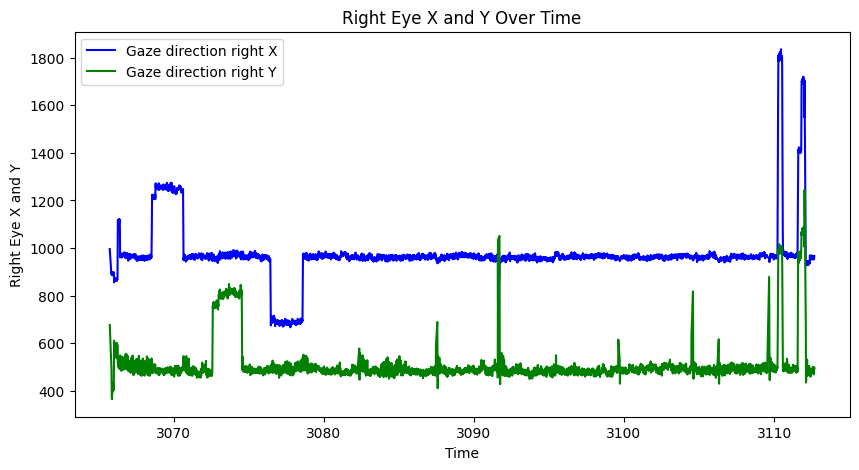

In [20]:
plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(calibration_trace_df['Seconds'], calibration_trace_df['Gaze point right X'], label='Gaze direction right X', color='blue')
plt.plot(calibration_trace_df['Seconds'], calibration_trace_df['Gaze point right Y'], label='Gaze direction right Y', color='green')
plt.title('Right Eye X and Y Over Time')
plt.xlabel('Time')
plt.ylabel('Right Eye X and Y')
plt.legend()
plt.show()

In [21]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=calibration_trace_df.index,
    y=calibration_trace_df['Gaze point right X'],
    mode='lines',
    name='Right Eye X',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=calibration_trace_df.index,
    y=calibration_trace_df['Gaze point right Y'],
    mode='lines',
    name='Right Eye Y',
    line=dict(color='green')
))

fig.update_layout(
    title='Right Eye X and Y Over Time',
    xaxis_title='Time',
    yaxis_title='Right Eye X and Y'
)

fig.show()

### Just Playing Here

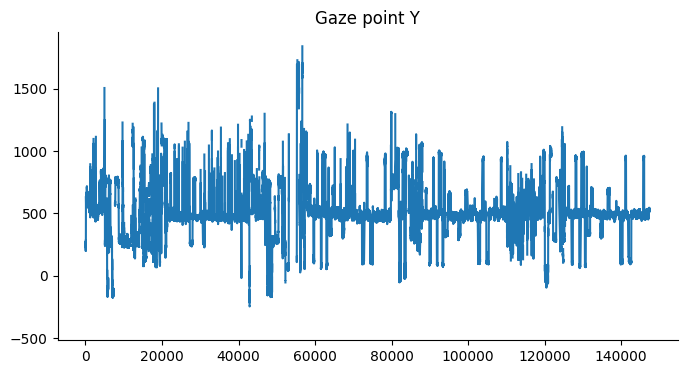

In [10]:
from matplotlib import pyplot as plt
eye_specific_df['Gaze point Y'].plot(kind='line', figsize=(8, 4), title='Gaze point Y')
plt.gca().spines[['top', 'right']].set_visible(False)

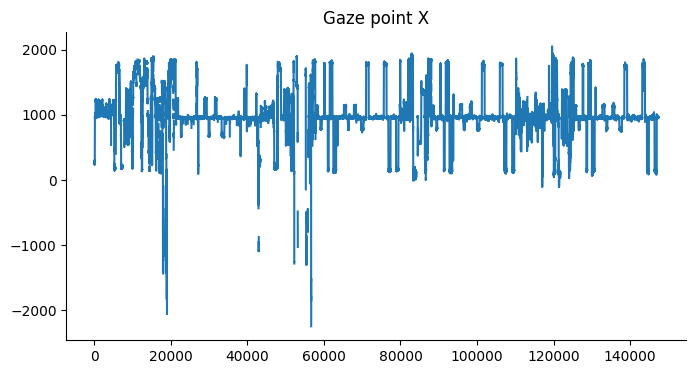

In [9]:
from matplotlib import pyplot as plt
eye_specific_df['Gaze point X'].plot(kind='line', figsize=(8, 4), title='Gaze point X')
plt.gca().spines[['top', 'right']].set_visible(False)